<a href="https://colab.research.google.com/github/nld-8832/stock-prediction/blob/master/1-1_Evaluate_Relation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

In [0]:
!pip install yfinance --upgrade

Requirement already up-to-date: yfinance in /usr/local/lib/python3.6/dist-packages (0.1.54)


In [0]:
import numpy as np
import pandas as pd
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.style.use('seaborn-darkgrid')
plt.rc('figure', figsize=(16,10))
plt.rc('lines', markersize=4)

import yfinance as yf

from sklearn.linear_model import LinearRegression

from datetime import date

### Get a sample stock price from 2019-01-01 to today

In [0]:
# Get the data of the Apple stock (code AAPL)
data = yf.download('AAPL','2018-12-31', date.today())
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-31,158.529999,159.360001,156.479996,157.740005,154.618546,35003500
2019-01-02,154.889999,158.850006,154.229996,157.919998,154.794983,37039700
2019-01-03,143.979996,145.720001,142.000000,142.190002,139.376251,91312200
2019-01-04,144.529999,148.550003,143.800003,148.259995,145.326126,58607100
2019-01-07,148.699997,148.830002,145.899994,147.929993,145.002686,54777800


### Extract the Close price column to plot

In [0]:
df = pd.DataFrame(data, columns=['Close'])
df = df.reset_index()
df.isna().values.any() # check for NaN

False

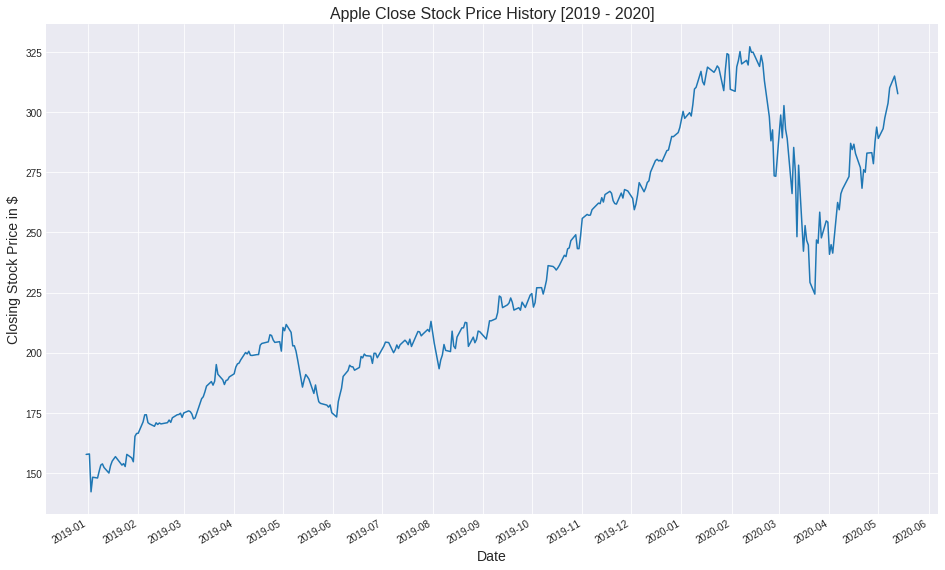

In [0]:
# Import matplotlib package for date plots

months = mdates.MonthLocator() # Get every year
dateFmt = mdates.DateFormatter('%Y-%m') # Set year format

# Create subplots to plot graph and control axes
fig, ax = plt.subplots()
ax.plot(df['Date'], df['Close'])

# Format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)

# Set figure title
plt.title('Apple Close Stock Price History [2019 - 2020]', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

### Get stock of Apple, Google, Microsoft, Amazon, Facebook via Yahoo Finance

In [0]:
def get_close_stock_price(codes, start_date, end_date):
    data = { code : yf.download(code, start_date, end_date) for code in codes }
    data = { key : pd.DataFrame(value, columns=['Close']).rename(columns={'Close': f'{key}'}) for key, value in data.items() }
    df = None
    for key, value in data.items():
        if df is None:
            df = value
        else:
            df = df.merge(value, left_index=True, right_index=True)
    return df

df = get_close_stock_price(['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'FB'], '2019-01-01', date.today())
df.to_csv('close_price_big_5.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [0]:
df = pd.read_csv('close_price_big_5.csv', index_col=['Date'], infer_datetime_format=True, parse_dates=['Date'])
df.head()

,AAPL,GOOGL,MSFT,AMZN,FB
Date,,,,,
2019-01-02,157.919998,1054.680054,101.120003,1539.130005,135.679993
2019-01-03,142.190002,1025.469971,97.400002,1500.280029,131.740005
2019-01-04,148.259995,1078.069946,101.930000,1575.390015,137.949997
2019-01-07,147.929993,1075.920044,102.059998,1629.510010,138.050003
2019-01-08,150.750000,1085.369995,102.800003,1656.579956,142.529999


In [0]:
df.index

DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15',
               ...
               '2020-04-30', '2020-05-01', '2020-05-04', '2020-05-05',
               '2020-05-06', '2020-05-07', '2020-05-08', '2020-05-11',
               '2020-05-12', '2020-05-13'],
              dtype='datetime64[ns]', name='Date', length=344, freq=None)

In [0]:
df_plot = df.reset_index().melt('Date', var_name='cols',  value_name='vals')
df_plot.isna().values.any()

False

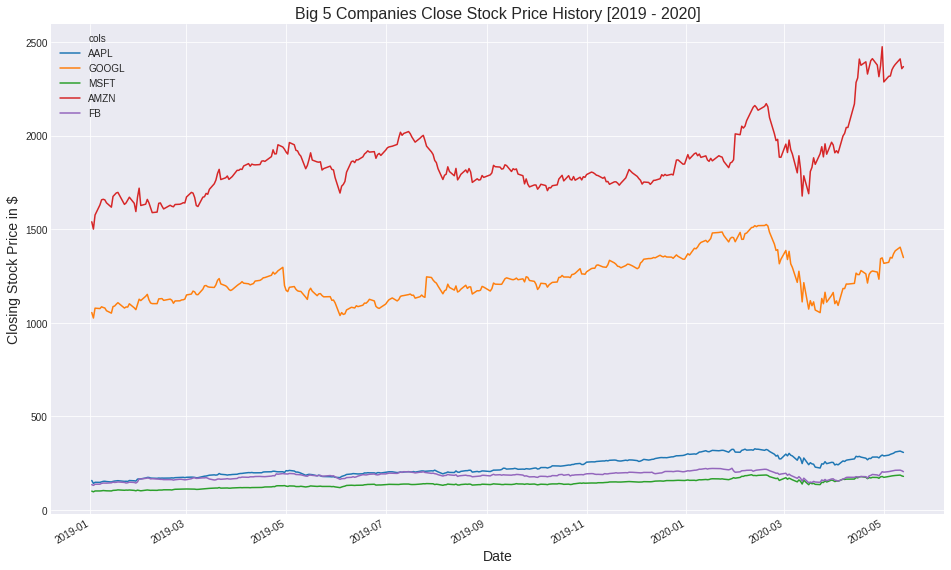

In [0]:
# Create subplots to plot graph and control axes
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(x="Date", y="vals", hue='cols', data=df_plot)

# Format the ticks
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

# Set figure title
plt.title('Big 5 Companies Close Stock Price History [2019 - 2020]', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

### Create X, y matrices for regression
Use history = number of days before prediction date

In [0]:
def create_Xy(df, history=1):
    '''df has index as date
    columns are stock price of the companies
    '''
    X, y, dates = [], [], []
    for row_idx in range(history, len(df)):
        X.append( df.iloc[row_idx-history:row_idx,:].values.reshape(-1) )
        print(df.iloc[row_idx-history:row_idx,:])
        print(df.iloc[row_idx,:])
        y.append( df.iloc[row_idx,:].values.reshape(-1) )
        dates.append(df.index[row_idx])
    X, y = np.array(X), np.array(y)
    return X, y, dates

X,y,dates = create_Xy(df, history=5)
# use 7/10 of the dataset to train (use past price to predict future price)
n_train = len(y) * 7 // 10
X_train, y_train, dates_train, X_test, y_test, dates_test = X[:n_train], y[:n_train], dates[:n_train], X[n_train:], y[n_train:], dates[n_train:]

                  AAPL        GOOGL        MSFT         AMZN          FB
Date                                                                    
2019-01-02  157.919998  1054.680054  101.120003  1539.130005  135.679993
2019-01-03  142.190002  1025.469971   97.400002  1500.280029  131.740005
2019-01-04  148.259995  1078.069946  101.930000  1575.390015  137.949997
2019-01-07  147.929993  1075.920044  102.059998  1629.510010  138.050003
2019-01-08  150.750000  1085.369995  102.800003  1656.579956  142.529999
AAPL      153.309998
GOOGL    1081.650024
MSFT      104.269997
AMZN     1659.420044
FB        144.229996
Name: 2019-01-09 00:00:00, dtype: float64
                  AAPL        GOOGL        MSFT         AMZN          FB
Date                                                                    
2019-01-03  142.190002  1025.469971   97.400002  1500.280029  131.740005
2019-01-04  148.259995  1078.069946  101.930000  1575.390015  137.949997
2019-01-07  147.929993  1075.920044  102.059998  1

### Create a Linear Regression Model to predict stock price

In [0]:
clf = LinearRegression()
clf.fit(X_train, y_train)
ypred = clf.predict(X_test)

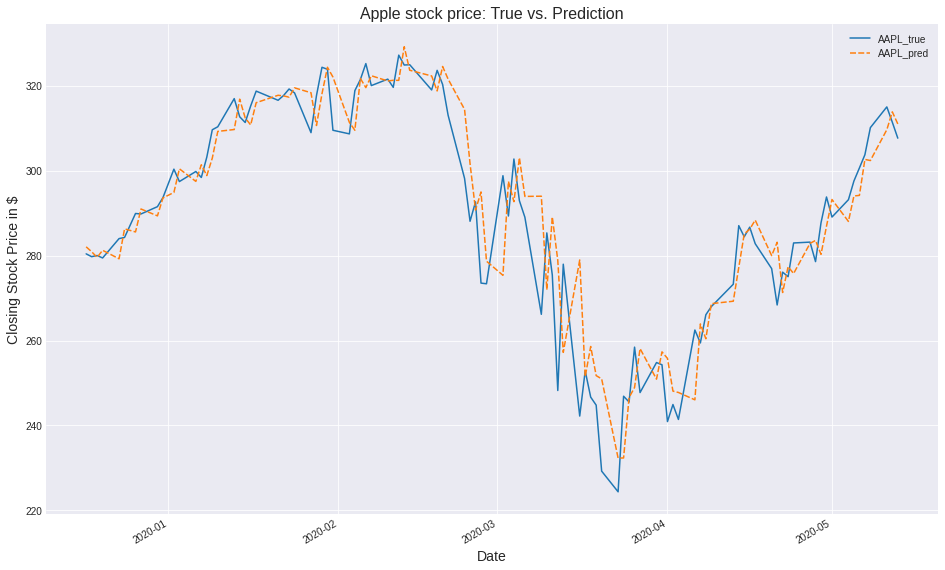

In [0]:
df_plot = pd.DataFrame({"AAPL_true": y_test[:,0], 'AAPL_pred': ypred[:,0]}, index=dates_test)

# Create subplots to plot graph and control axes
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(data=df_plot)

# Format the ticks
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

# Set figure title
plt.title('Apple stock price: True vs. Prediction', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

In [0]:
# Evaluate original performance

from sklearn import metrics

#Error metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, ypred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, ypred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, ypred)))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print('Mean Absolute Percentage Error: %', mean_absolute_percentage_error(y_test, ypred))

#Accuracy metrics
from sklearn.metrics import explained_variance_score
print('R2 Score:', metrics.r2_score(y_test, ypred))
print('Explained Variance Score:', explained_variance_score(y_test, ypred))

Mean Absolute Error: 17.237497919177542
Mean Squared Error: 965.4799665125014
Root Mean Squared Error: 31.072173508020025
Mean Absolute Percentage Error: % 2.576825678950891
R2 Score: 0.8655238385320416
Explained Variance Score: 0.8785719426049114


In [0]:
# Get the data of the Apple stock (code AAPL)
data = yf.download('AAPL','2019-01-01', date.today())
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,154.889999,158.850006,154.229996,157.919998,154.794983,37039700
2019-01-03,143.979996,145.720001,142.000000,142.190002,139.376251,91312200
2019-01-04,144.529999,148.550003,143.800003,148.259995,145.326126,58607100
2019-01-07,148.699997,148.830002,145.899994,147.929993,145.002686,54777800
2019-01-08,149.559998,151.820007,148.520004,150.750000,147.766861,41025300


# Exercise
1. Play with the above code to get familiar with stock price data and ways to create training data ( X = past stock price, y = future stock price )
2. Investigate if stock price of Big 5 companies are related to each other ( “FAAMG”—Facebook, Amazon, Apple, Microsoft, and Google )
3. Determine the features that could predict future stock price ( stock price from Yahoo Finance could be considered as raw features, create new features if needed )
4. Build a linear regression model to predict future stock price
5. Evaluate your model performance

# Investigate if stock price of Big 5 companies are related to each other

**General correlation trend (period: 2019-01-01 till today)**



In [0]:
# Calculating correlation matrix
returns = pd.DataFrame()
for stock in df:
    if stock not in returns:
        returns[stock] = np.log(df[stock]).diff()
returns = returns[1:]        

returns.corr().style.background_gradient(cmap='coolwarm')

,AAPL,GOOGL,MSFT,AMZN,FB
AAPL,1.000000,0.779377,0.836499,0.664358,0.723621
GOOGL,0.779377,1.000000,0.828157,0.688643,0.778910
MSFT,0.836499,0.828157,1.000000,0.734960,0.761425
AMZN,0.664358,0.688643,0.734960,1.000000,0.652691
FB,0.723621,0.778910,0.761425,0.652691,1.000000


Closing stock price of all 5 companies are, generally, highly correlated.
Lowest correlation among the 5 companies would be Amazon (correlation range: 0.654 to 0.736) being moderately correlated to the others.

**Zoom-in period 1 (2019-01-01 to 2019-04-01)**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


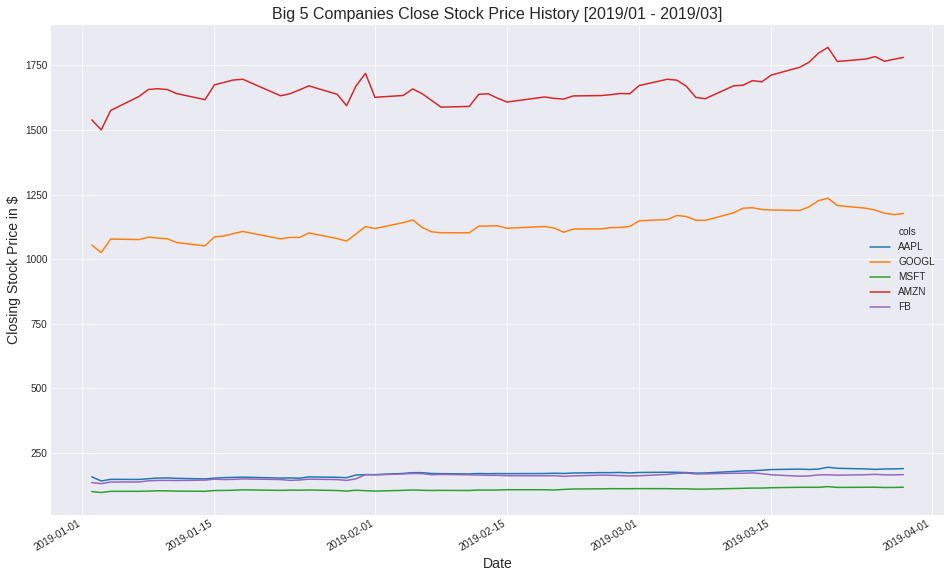

,AAPL,GOOGL,MSFT,AMZN,FB
AAPL,1.000000,0.696642,0.757448,0.616659,0.462962
GOOGL,0.696642,1.000000,0.706373,0.791695,0.645935
MSFT,0.757448,0.706373,1.000000,0.707660,0.296507
AMZN,0.616659,0.791695,0.707660,1.000000,0.542211
FB,0.462962,0.645935,0.296507,0.542211,1.000000


In [0]:
# Getting data and plotting
df1 = get_close_stock_price(['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'FB'], '2019-01-01', '2019-04-01')
df1.to_csv('close_price_big_5.csv')
df1 = pd.read_csv('close_price_big_5.csv', index_col=['Date'], infer_datetime_format=True, parse_dates=['Date'])

df1_plot = df1.reset_index().melt('Date', var_name='cols',  value_name='vals')
df1_plot.isna().values.any()

fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(x="Date", y="vals", hue='cols', data=df1_plot)

loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

plt.title('Big 5 Companies Close Stock Price History [2019/01 - 2019/03]', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Stock Price in $', fontsize=14)

fig.autofmt_xdate()
plt.show()

# Calculating correlation matrix
returns = pd.DataFrame()
for stock in df1:
    if stock not in returns:
        returns[stock] = np.log(df1[stock]).diff()
returns = returns[1:]        

returns.corr().style.background_gradient(cmap='coolwarm')

All stock prices seems to be highly correlated, with the exception of Facebook. 

**Zoom-in period 2 (2019-04-01 to 2019-08-01)**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


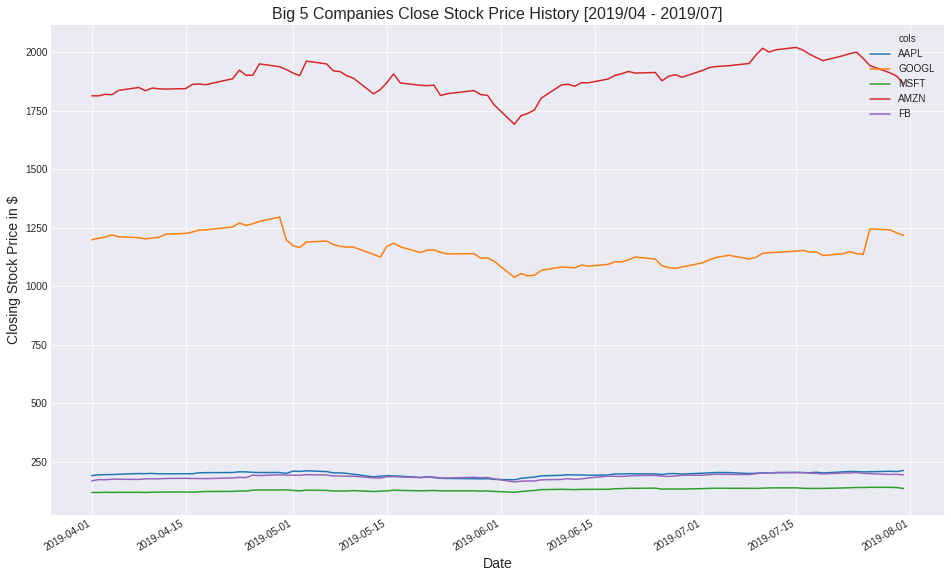

,AAPL,GOOGL,MSFT,AMZN,FB
AAPL,1.000000,0.367215,0.437251,0.530031,0.398969
GOOGL,0.367215,1.000000,0.485665,0.465792,0.501169
MSFT,0.437251,0.485665,1.000000,0.732625,0.631088
AMZN,0.530031,0.465792,0.732625,1.000000,0.654356
FB,0.398969,0.501169,0.631088,0.654356,1.000000


In [0]:
# Getting data and plotting
df1 = get_close_stock_price(['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'FB'], '2019-04-01', '2019-08-01')
df1.to_csv('close_price_big_5.csv')
df1 = pd.read_csv('close_price_big_5.csv', index_col=['Date'], infer_datetime_format=True, parse_dates=['Date'])

df1_plot = df1.reset_index().melt('Date', var_name='cols',  value_name='vals')
df1_plot.isna().values.any()

fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(x="Date", y="vals", hue='cols', data=df1_plot)

loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

plt.title('Big 5 Companies Close Stock Price History [2019/04 - 2019/07]', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Stock Price in $', fontsize=14)

fig.autofmt_xdate()
plt.show()

# Calculating correlation matrix
returns = pd.DataFrame()
for stock in df1:
    if stock not in returns:
        returns[stock] = np.log(df1[stock]).diff()
returns = returns[1:]        

returns.corr().style.background_gradient(cmap='coolwarm')

Relation between closing stock prices appears to dive down during this period. With the exception of Microsoft and Amazon being moderately correlated; the rest are only loosely connected to each other.

**Zoom-in period 3 (2019-08-01 to 2019-12-01)**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


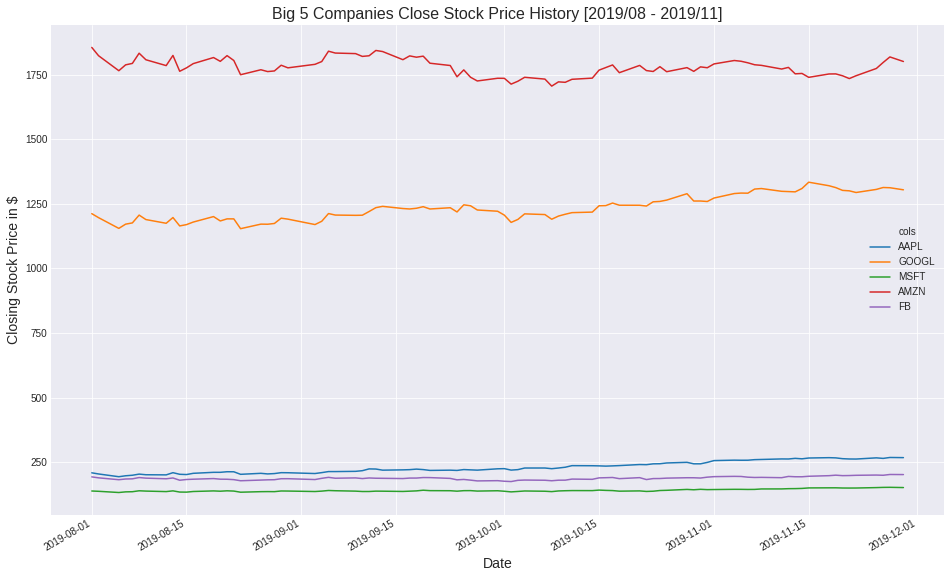

,AAPL,GOOGL,MSFT,AMZN,FB
AAPL,1.000000,0.756491,0.695106,0.664279,0.626623
GOOGL,0.756491,1.000000,0.852073,0.760959,0.697461
MSFT,0.695106,0.852073,1.000000,0.808135,0.750580
AMZN,0.664279,0.760959,0.808135,1.000000,0.751933
FB,0.626623,0.697461,0.750580,0.751933,1.000000


In [0]:
# Getting data and plotting
df1 = get_close_stock_price(['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'FB'], '2019-08-01', '2019-12-01')
df1.to_csv('close_price_big_5.csv')
df1 = pd.read_csv('close_price_big_5.csv', index_col=['Date'], infer_datetime_format=True, parse_dates=['Date'])

df1_plot = df1.reset_index().melt('Date', var_name='cols',  value_name='vals')
df1_plot.isna().values.any()

fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(x="Date", y="vals", hue='cols', data=df1_plot)

loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

plt.title('Big 5 Companies Close Stock Price History [2019/08 - 2019/11]', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Stock Price in $', fontsize=14)

fig.autofmt_xdate()
plt.show()

# Calculating correlation matrix
returns = pd.DataFrame()
for stock in df1:
    if stock not in returns:
        returns[stock] = np.log(df1[stock]).diff()
returns = returns[1:]        

returns.corr().style.background_gradient(cmap='coolwarm')

Slight increase trend. Price at this point is mostly moderately correlated.

**Zoom-in period 4 (2019-12-01 to 2020-03-01)**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


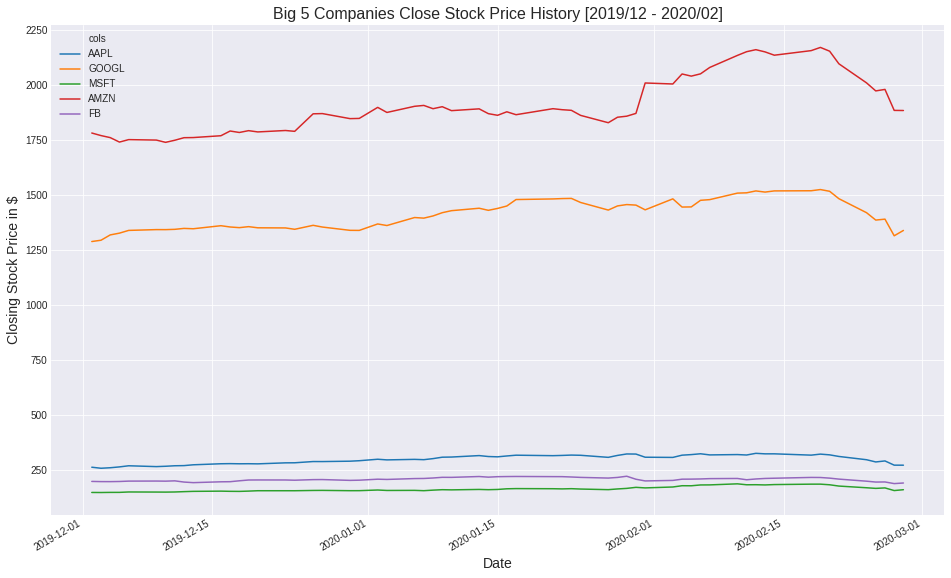

,AAPL,GOOGL,MSFT,AMZN,FB
AAPL,1.000000,0.666246,0.763972,0.379051,0.640488
GOOGL,0.666246,1.000000,0.742422,0.465256,0.568869
MSFT,0.763972,0.742422,1.000000,0.541964,0.552634
AMZN,0.379051,0.465256,0.541964,1.000000,0.286361
FB,0.640488,0.568869,0.552634,0.286361,1.000000


In [0]:
# Getting data and plotting
df1 = get_close_stock_price(['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'FB'], '2019-12-01', '2020-03-01')
df1.to_csv('close_price_big_5.csv')
df1 = pd.read_csv('close_price_big_5.csv', index_col=['Date'], infer_datetime_format=True, parse_dates=['Date'])

df1_plot = df1.reset_index().melt('Date', var_name='cols',  value_name='vals')
df1_plot.isna().values.any()

fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(x="Date", y="vals", hue='cols', data=df1_plot)

loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

plt.title('Big 5 Companies Close Stock Price History [2019/12 - 2020/02]', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Stock Price in $', fontsize=14)

fig.autofmt_xdate()
plt.show()

# Calculating correlation matrix
returns = pd.DataFrame()
for stock in df1:
    if stock not in returns:
        returns[stock] = np.log(df1[stock]).diff()
returns = returns[1:]        

returns.corr().style.background_gradient(cmap='coolwarm')

Considerate decrease in correlation. Amazon is only slightly correlated to the rest. 

**Zoom-in period 5 (2020-03-01 to today)**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


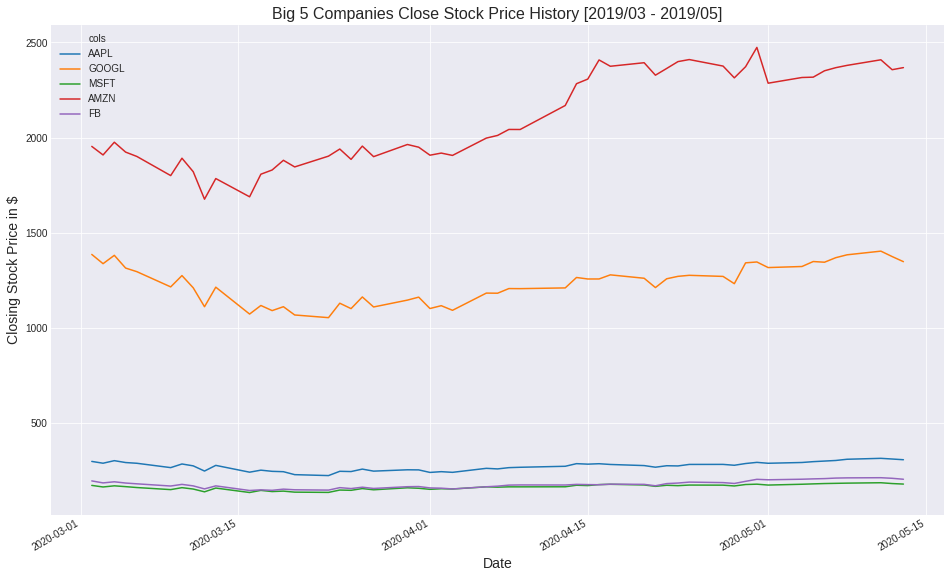

,AAPL,GOOGL,MSFT,AMZN,FB
AAPL,1.000000,0.940202,0.955559,0.784620,0.912151
GOOGL,0.940202,1.000000,0.939276,0.786110,0.943755
MSFT,0.955559,0.939276,1.000000,0.804789,0.923373
AMZN,0.784620,0.786110,0.804789,1.000000,0.759122
FB,0.912151,0.943755,0.923373,0.759122,1.000000


In [0]:
# Getting data and plotting

df1 = get_close_stock_price(['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'FB'], '2020-03-01', date.today())
df1.to_csv('close_price_big_5.csv')
df1 = pd.read_csv('close_price_big_5.csv', index_col=['Date'], infer_datetime_format=True, parse_dates=['Date'])

df1_plot = df1.reset_index().melt('Date', var_name='cols',  value_name='vals')
df1_plot.isna().values.any()

fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(x="Date", y="vals", hue='cols', data=df1_plot)

loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

plt.title('Big 5 Companies Close Stock Price History [2019/03 - 2019/05]', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Stock Price in $', fontsize=14)

fig.autofmt_xdate()
plt.show()

# Calculating correlation matrix
returns = pd.DataFrame()
for stock in df1:
    if stock not in returns:
        returns[stock] = np.log(df1[stock]).diff()
returns = returns[1:]        

returns.corr().style.background_gradient(cmap='coolwarm')

Significant positive correlation in the last 2 months. Lowest correlation point, Amazon, is still considerably connected to the rest.